In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.notebook as tq
from tqdm import trange
import pickle

In [8]:
class NeuronModelConfig:
    """
    Configuration class that defines the neuron model as a collection of other functions
    """
    def __init__(self, params, input_potential, rate_dendrite_integral, initial_rate_soma, 
                 rate_soma, refractory_kernel, dendritic_kernel):
        
        self.params = params
        self.input_potential = input_potential
        self.rate_dendrite_integral = rate_dendrite_integral
        self.initial_rate_soma = initial_rate_soma
        self.rate_soma = rate_soma
        self.refractory_kernel = refractory_kernel
        self.dendritic_kernel = dendritic_kernel

        
def default_params():
    """
    Generate a dictionary with the default neuron model parameters.

    Return
    ------
        params (dict): Parameters defining the neuron model.

    """
    params = {}
    
    # input potential parameters
    params['L'] = 10
    params['I_d'] = 1
    params['I_s'] = 1
    params['x_d'] = 8
    
    # dendritic rate parameters
    params['lambda_d'] = .1
    params['B'] = 1
    params['v_B'] = 2
    
    # somatic rate parameters
    params['lambda_s'] = .01
    params['R'] = 1
    params['delta_R'] = 1
    params['D'] = 2
    params['delta_D'] = 2
    
    params['tau'] = 10*1e-3 # hypothetical membrane time constant for scaling time.

    # gaussian mask parameters
    params['mu'] = 8
    params['sigma'] = 0.5
    
    # gaussian input parameters
    params['xd_I'] = 8
    params['sigma_I'] = 0.5
    
    params['tau_syn'] = 0.3
    
    return params


def input_potential_uniform(X, config):
    """
    Estimate the input potnential at locations X for a neuron with parameters given by params. Localized somatic and dendritic input.

    Args
    ----
        X (Ndarray): 1xN array of spatial locations along the dendrite.
        params (dict): Dicionary of parameter values defining the neuron model.

    Return
    ------
        Array of input potentials corresponing to the locations given by the input X.
    """
    params = config.params
    
    I_s = params['I_s']
    I_d = params['I_d']
    x_d = params['x_d']
    L = params['L']
    
    N = 100 # approximation of infinite sum
    n = np.arange(-N, N+1) # n = {-N, -(N-1), ..., 0, ..., (N-1), N}
    
    if type(X)==int:  # if only a point estimate is needed at location X
        dx = 0.00001
        h = np.sum((I_s/2)*(np.exp(-1*np.abs(X-2*n*L+dx))+np.exp(-1*np.abs(X-2*n*L-dx))) + (I_d/2)*(np.exp(-1*np.abs(X-2*n*L-x_d)) + np.exp(-1*np.abs(X-2*n*L+x_d))))
    else: # get estimate of the input potential for each entry of X
        h = np.zeros(len(X))
        dx = X[1]-X[0]
        for i, x in enumerate(X): 
            h[i] = np.sum((I_s/2)*(np.exp(-1*np.abs(x-2*n*L+dx)) + np.exp(-1*np.abs(x-2*n*L-dx))) + (I_d/2)*(np.exp(-1*np.abs(x-2*n*L-x_d)) + np.exp(-1*np.abs(x-2*n*L+x_d))))
        
    return h

def relu(x):
    y=x
    y[x<0] = 0
    
    return y

def refractory_kernel_square(t, config):
    
    params = config.params
    
    R = params['R']
    delta_R = params['delta_R']
    
    ref = -R*np.heaviside(delta_R - t, 1)
    
    return ref

def dendritic_kernel_square(t, config):
    params = config.params
    
    D = params['D']
    delta_D = params['delta_D']
    
    d_spike = D*np.heaviside(delta_D - t, 1)
    
    return d_spike


def rate_dendrite_integral(t, t_hat, h, dx, config):
    """
    Integral of the dendritic hazard rate over space. Non-spatial case.

    Args
    ----
        t (TYPE): DESCRIPTION.
        t_hat (TYPE): DESCRIPTION.
        params (TYPE): DESCRIPTION.

    Return
    ------
        continuous_part (TYPE): DESCRIPTION.
        continuous_part_vec (TYPE): DESCRIPTION.
        discrete_part (TYPE): DESCRIPTION.

    """
    params = config.params
    
    lambda_d = params['lambda_d']
    L = params['L']
    v_B = params['v_B']
    B = params['B']    
    
    continuous_part  = lambda_d*np.sum(h)*dx
    discrete_part = lambda_d*B*np.heaviside(L/v_B - (t-t_hat), 1)
    continuous_part_vec = lambda_d*h
    
    return continuous_part, continuous_part_vec, discrete_part


def initial_rate_soma(t, t_hat, h_0, config):
    """
    Calculate the initial somatic hazard rate.

    Args
    ----
        t (float): Current time.
        t_hat (float): Time of the last somatic spike.
        h_0 (float): Input potential evaluated at x=0.
        params (dict): Parameters defining the neuron model.

    Return
    ------
        rate (float): initial somatic hazard rate evaluated at time t given t_hat

    """
    
    params = config.params
    refractory_kernel = config.refractory_kernel
    
    lambda_s = params['lambda_s']
    ref = refractory_kernel(t=(t-t_hat), config=config)
    rate = lambda_s*np.exp(h_0 + ref) 
    
    return rate

def rate_soma(t, t_p, t_hat, h_0, config):
    """
    Calculate the soamtic hazard rate (after a dendritic spike has ocurred).

    Args
    ----
        t (float): Current time.
        t_p (float): Time of the last dendritic spike.
        t_hat (float): Time of the last somatic spike.
        params (dict): Parameters defining the neuron model.

    Return

        rate (TYPE): Somatic hazard rate evaluated at time t given t_hat and t_p.

    """
    params = config.params
    refractory_kernel = config.refractory_kernel
    dendritic_kernel = config.dendritic_kernel
    
    lambda_s = params['lambda_s']
    ref = refractory_kernel(t=(t-t_hat), config=config)
    d_spike = dendritic_kernel(t=(t-t_p), config=config)
    rate = lambda_s*np.exp(h_0 + ref + d_spike)
    
    return rate

def survivor_dendrite(t_vec, dt, dx, h, config):
    """
    Calculate the dendritic survivor function

    Args
    ----
        t_vec (numpy array): A vector representing t-t_hat
        dt (float): Integration timestep
        rate_dendrite (function): Dendriic hazard rate
        params (dict): Parameters defining the neuron model.

    Return
    ------
        survivor_function (numpy array): Dendritic survivor function

    """
    rate_dendrite_integral = config.rate_dendrite_integral
    
    t_hat = 0 # we can assume this to be zero without loss of generality
    
    rates = np.zeros(len(t_vec))
    for i, t in enumerate(t_vec): 
        continuous_part, continuous_part_vec, discrete_part = rate_dendrite_integral(t=t, t_hat=t_hat, h=h, dx=dx, config=config)
        rates[i] = continuous_part + discrete_part
        
    survivor_function = np.exp(-np.cumsum(rates)*dt)
        
    return survivor_function


def survivor_initial_soma(t_vec, dt, h_0, config):
    """
    Calculate the initial somatic survivor function.
    
    Args
    ----
    t_vec (numpy array): A vector representing t-t_hat
    dt (float): Integration timestep
    rate_dendrite (function): Dendriic hazard rate
    params (dict): Parameters defining the neuron model.

    Return
    ------
        survivor_function (numpy array): Initial somatic survivor function

    """    
    initial_rate_soma = config.initial_rate_soma
    
    t_hat = 0 # we can assume this to be zero without loss of generality
    
    rates = np.zeros(len(t_vec))
    for i, t in enumerate(t_vec): 
        rates[i] = initial_rate_soma(t=t, t_hat=t_hat, h_0=h_0, config=config)
        
    survivor_function = np.exp(-np.cumsum(rates)*dt)
    
    return survivor_function

# NOTE: The above two functions are essentially the same 
# and can be possible combined into one function with a different hazard rates


def survivor_conditional_soma(t_vec, dt, h_0, config):
    """
    Calculate the conditional somatic survivor function (dependent on the last somatic and dendritic spike times).
    
    Args
    ----
    t_vec (numpy array): A vector representing t-t_p
    dt (float): Integration timestep
    rate_dendrite (function): Dendriic hazard rate
    params (dict): Parameters defining the neuron model.

    Return
    ------
        survivor_function (numpy array): Initial somatic survivor function

    """    
    rate_soma = config.rate_soma
    
    t_p_matrix, t_matrix = np.meshgrid(t_vec, t_vec)
    t_hat = 0 # we can assume this to be zero without loss of generality 
    
    rate_matrix = rate_soma(t=t_matrix, t_p=t_p_matrix, t_hat=t_hat, h_0=h_0, config=config)
    
    rate_matrix_lower = np.tril(rate_matrix)
    survivor_function = np.exp(-np.cumsum(rate_matrix_lower, axis=0)*dt)

    return survivor_function

In [9]:
def integrate_survivor_one_dendritic_spike(t_max, config):
    """
    Numerically integrate the marginal survivor function.

    Args
    ----
        t_max (TYPE): DESCRIPTION.
        params (TYPE): DESCRIPTION.
        epsilon (TYPE): DESCRIPTION.
        dendritic_rate (func): Integral of the dendritic hazard rate over space. Can we for the spatial or non-spatial case. 
        survivor_d (func): Survivor function of the dendrite. Can be for the spatial or non-spatial case.

    Return
    ------
        S_theory TYPE: Marginal somatic survivor probability as a function of time
        t_prime_vec TYPE: The times corresponding to each value in S_theory

    """
    
    params = config.params
    input_potential = config.input_potential
    rate_dendrite_integral = config.rate_dendrite_integral
    
    t_hat = 0
    dtp = t_max/10000
    epsilon = 1e-7
    
    L = params['L']
    v_B = params['v_B']
    dx = v_B*dtp
    x_grid = np.linspace(0, L, int(L/dx)+1)
    h = input_potential(X=x_grid, config=config) 
    
    t_prime_vec = np.linspace(0, t_max, int(t_max/dtp)+1)
    
    S_d = survivor_dendrite(t_vec=t_prime_vec, dt=dtp, dx=dx, h=h, config=config)
    
    continuous_part, _, discrete_part  = rate_dendrite_integral(t=t_prime_vec, t_hat=t_hat, h=h, dx=dx, config=config)
    rate_d = continuous_part + discrete_part
    
    S_s0 = survivor_initial_soma(t_vec=t_prime_vec, dt=dtp, h_0=h[0], config=config)
    
    S_s = survivor_conditional_soma(t_vec=t_prime_vec, dt=dtp, h_0=h[0], config=config)
    
    S_tmp = survivor_dendrite(t_vec=t_prime_vec, dt=dtp, dx=dx, h=h, config=config)*survivor_initial_soma(t_vec=t_prime_vec, dt=dtp, h_0=h[0], config=config)
    S_theory = S_s0*S_d
    
    for i, t in enumerate(t_prime_vec):    
        S_theory[i] += np.sum(S_tmp[:i]*rate_d[:i]*S_s[i, :i])*dtp
        
    return S_theory, t_prime_vec


In [10]:
def estimate_t_max(epsilon, config):
    
    initial_rate_soma = config.initial_rate_soma
    input_potential = config.input_potential
    dt = 0.01
    rate_integral = 0
    n=0
    
    h_0 = input_potential(X=0, config=config) 
    
    while rate_integral<np.log(1/epsilon):
        rate_integral += initial_rate_soma(t=n*dt, t_hat=0, h_0=h_0, config=config)*dt
        n += 1
        
    t_max = n*dt
    
    return t_max

In [11]:
def ensemble_response_theory(I_s_vec, I_d_vec, integrate_survivor, config):
    """
    Calucluate the stationary firing rate and cv using the integration method.

    Args
    ----
        I_s_vec (TYPE): DESCRIPTION.
        I_d_vec (TYPE): DESCRIPTION.
        params (TYPE): DESCRIPTION.
        dendritic_rate (TYPE): DESCRIPTION.
        survivor_dendrite (TYPE): DESCRIPTION.

    Return
    ------
        A_inf_mat (TYPE): DESCRIPTION.

    """
    params = config.params
    epsilon = 0.001
    tau = params['tau']
    
    A = np.zeros((len(I_d_vec), len(I_s_vec)))
    cv = np.zeros((len(I_d_vec), len(I_s_vec)))
    
    i=0
    for I_s in tq.tqdm(I_s_vec, desc="I_s Loop", position=0):
        
        params['I_s'] = I_s
        
        j=0
        for I_d in tq.tqdm(I_d_vec, desc="I_d Loop", position=1, leave=False):
            
            params['I_d'] = I_d
            
            t_max = estimate_t_max(epsilon=epsilon, config=config)
            
            S_theory, t_vec_theory = integrate_survivor(t_max=t_max, config=config)
            dt = t_vec_theory[1]
            
            A[j, i] = (1/(np.sum(S_theory)*dt*tau))    
            
            T_first_moment = (np.sum(S_theory)*dt)
            T_second_moment = 2*np.sum(S_theory*t_vec_theory)*dt
            cv[j, i] = np.sqrt((T_second_moment - T_first_moment**2) / T_first_moment**2)
            
            j+=1
        i+=1

    return A, cv



def ensemble_response_monte_carlo(I_s_vec, I_d_vec, monte_carlo, config):
    
    nb_steps = int(1e6)
    nb_neurons = 1000
    
    A = np.zeros((len(I_d_vec), len(I_s_vec)))
    cv = np.zeros((len(I_d_vec), len(I_s_vec)))
    nb_somatic_spikes = np.zeros((len(I_d_vec), len(I_s_vec)))
    nb_dendritic_spikes = np.zeros((len(I_d_vec), len(I_s_vec)))
    
    
    i=0
    for I_s in tq.tqdm(I_s_vec, desc="I_s Loop", position=0):

        params['I_s'] = I_s
        
        # Monte carlo takes a long time to get spikes at low inputs, so I have incrementally increased the step size to speed up the simulation.
        if I_s<=1.25: 
            dt = 1
        if I_s>1.25 and I_s<=2.5:
            dt = 0.1
        if I_s>2.5:
            dt = 0.01
        
        j=0
        for I_d in tq.tqdm(I_d_vec, desc="I_d Loop", position=1, leave=False):
            
            params['I_d'] = I_d


            somatic_spike_train, dendritic_spike_train, _ = monte_carlo(nb_steps=nb_steps, nb_neurons=nb_neurons, dt=dt, 
                                                                        config=config, sample_dendritic_spike_locations=False)
    
            intervals, As, cvs = calcualte_statistics_monte_carlo(spike_train=somatic_spike_train, dt=dt, config=config)
        
            A[j, i] = np.mean(As)
            cv[j, i] = np.mean(cvs)
            
            nb_somatic_spikes[j, i] = np.sum(somatic_spike_train)
            nb_dendritic_spikes[j, i] = np.sum(dendritic_spike_train)
            
            j+=1
        i+=1
    
    return A, cv, nb_somatic_spikes, nb_dendritic_spikes

def calcualte_statistics_monte_carlo(spike_train, dt, config): 
    
    params = config.params
    intervals = []
    tau=params['tau']
    
    nb_neurons, nb_steps = np.shape(spike_train)
    As = np.zeros(nb_neurons)
    cvs = np.zeros(nb_neurons)
    
    t = np.arange(nb_steps)*dt
    
    #spike_train = spike_train[:, :int(nb_steps/2)] #only use last half
    #t = t[:int(nb_steps/2)]
    
    for n in range(nb_neurons):
        
        spike_times = t[spike_train[n,:]==1]
        intervals_tmp = np.diff(spike_times)
        
        intervals.append(list(intervals_tmp))
        
        mu = np.mean(intervals_tmp)
        sigma = np.std(intervals_tmp)
        
        As[n] = 1/(mu*tau)
        cvs[n] = sigma/mu
    
    return intervals, As, cvs

def calcualte_statistics_monte_carlo2(spike_train, dt, config): 
    
    params = config.params
    intervals = []
    tau=params['tau']
    
    A_tmp = np.mean(spike_train, axis=0)/dt
    
    A_tmp_len = len(A_tmp)
    last_quarter = A_tmp_len - int(A_tmp_len/4)
            
    A = np.mean(A_tmp[last_quarter:])/tau
    
    return A


In [12]:
def monte_carlo_one_dendritic_spike(nb_steps, nb_neurons, dt, config, sample_dendritic_spike_locations=False):
    """
    Monte Carlo sample the two-compartment renewal model.
    
    Args
    ----
        nb_steps (TYPE): DESCRIPTION.
        dt (TYPE): DESCRIPTION.
        params (TYPE): DESCRIPTION.
        dendritic_rate (TYPE): DESCRIPTION.

    Return
    ------
        intervals (list): Somatic interspike intervals. 
        somatic_spike_train (Ndarray): Array of spikes (0's and 1's)
        dendritic_spike_train (Ndarray): Array of spikes (0's and 1's)

    """
    
    input_potential = config.input_potential
    rate_dendrite_integral = config.rate_dendrite_integral
    initial_rate_soma = config.initial_rate_soma
    rate_soma = config.rate_soma
    

    # define grid of plocations along the dendrite
    L = params['L']
    v_B = params['v_B']
    dx = v_B*dt
    x_grid = np.linspace(0, L, int(L/dx)+1)
    
    # evaluate the input potential along the dendrite
    h = input_potential(X=x_grid, config=config) 
    
    somatic_intervals = []
    last_s_spike = np.zeros(nb_neurons) 
    last_d_spike = np.zeros(nb_neurons)
    last_d_spike_location = np.zeros(nb_neurons)
    
    somatic_spike_train = np.zeros((nb_neurons, nb_steps))
    dendritic_spike_train = np.zeros((nb_neurons, nb_steps))
    dendritic_spike_locations = np.zeros((nb_neurons, nb_steps))

    dendrite_alive = np.asarray([True]*nb_neurons)
    
    for i in range(nb_steps):
        
        continuous_part, continuous_part_vec, discrete_part = rate_dendrite_integral(t=i*dt, t_hat=last_s_spike*dt, h=h, dx=dx, config=config)
        prob_d = 1 - np.exp(-(continuous_part+discrete_part)*dt)
        
        rand_d = np.random.rand(nb_neurons)
        d_spike_boolean = (rand_d<=prob_d)
        
        d_spike_update = np.logical_and(d_spike_boolean, dendrite_alive)
        last_d_spike[d_spike_update] = i
        dendrite_alive[d_spike_update] = False
        
         # sample dendritic spike locations
        if sample_dendritic_spike_locations==True:
            
            r1 = np.random.rand(nb_neurons)
            
            # check if dendritic spike occurs at BAP location
            BAP_location_boolean = (r1<=(discrete_part/(continuous_part+discrete_part)))
            
            updated_BAP_location = np.logical_and(BAP_location_boolean, d_spike_update)
            
            last_d_spike_location[updated_BAP_location] = v_B*(i-last_s_spike[updated_BAP_location])*dt
            
            dendritic_spike_locations[updated_BAP_location, i] = v_B*(i-last_s_spike[updated_BAP_location])*dt
            
            # get locations that are left to sample
            continuous_location_boolean = np.logical_and(np.logical_not(BAP_location_boolean), d_spike_update)
            
            while np.sum(continuous_location_boolean)>0: 
                x_rand = np.random.randint(low=0, high=len(x_grid), size=nb_neurons)
                r2 = np.random.rand(nb_neurons)
    
                continuous_spiked_boolean = (r2 <= continuous_part_vec[x_rand]/(continuous_part+discrete_part))
                
                updated_continuous_location = np.logical_and(continuous_spiked_boolean, continuous_location_boolean)
                last_d_spike_location[updated_continuous_location] = x_grid[x_rand[updated_continuous_location]]
                dendritic_spike_locations[updated_continuous_location, i] = x_grid[x_rand[updated_continuous_location]]
                
                continuous_location_boolean = np.logical_and(continuous_location_boolean, np.logical_not(continuous_spiked_boolean))
                
        
        
                
        # 1xnb_neurons size array of rates    
        initial_rate_soma_tmp = initial_rate_soma(t=i*dt, t_hat=last_s_spike*dt, h_0=h[0], config=config)
        rate_soma_tmp = rate_soma(t=i*dt, t_p=last_d_spike*dt, t_hat=last_s_spike*dt, h_0=h[0], config=config)
        
        prob_s = 1 - np.exp(-rate_soma_tmp*dt)
        prob_s[dendrite_alive] = 1 - np.exp(-initial_rate_soma_tmp[dendrite_alive]*dt)
    
        rand_s = np.random.rand(nb_neurons)
       
        s_spike_boolean = (rand_s<=prob_s)
        
        #d_spike_update = np.logical_and(d_spike_boolean, dendrite_alive)
        # update spike train and last spike index
        #dendritic_spike_train[d_spike_update,i] = 1
        #last_d_spike[d_spike_update] = i
        #dendrite_alive[d_spike_update] = False
        
        reset_dendrite = np.logical_and(s_spike_boolean, np.logical_not(dendrite_alive))
        dendrite_alive[reset_dendrite]=True
        
        somatic_spike_train[s_spike_boolean,i] = 1
        last_s_spike[s_spike_boolean] = i       
        


    return somatic_spike_train, dendritic_spike_train, dendritic_spike_locations

In [13]:
I_d_vec = np.linspace(0, 5, 3) # currents to run analysis over
I_s_vec = np.linspace(0, 5, 31)


A_theory_all = []
cv_theory_all = []
params = default_params()


uniform_config = NeuronModelConfig(params=params, input_potential=input_potential_uniform, rate_dendrite_integral=rate_dendrite_integral, 
                             initial_rate_soma=initial_rate_soma, rate_soma=rate_soma, 
                                refractory_kernel=refractory_kernel_square, dendritic_kernel=dendritic_kernel_square)

A_theory, cv_theory = ensemble_response_theory(I_s_vec=I_s_vec, I_d_vec=I_d_vec, 
                                               integrate_survivor=integrate_survivor_one_dendritic_spike, 
                                               config=uniform_config)

params['D'] = 0
uniform_passive_config = NeuronModelConfig(params=params, input_potential=input_potential_uniform, rate_dendrite_integral=rate_dendrite_integral, 
                             initial_rate_soma=initial_rate_soma, rate_soma=rate_soma, 
                                refractory_kernel=refractory_kernel_square, dendritic_kernel=dendritic_kernel_square)

A_theory_passive, cv_theory_passive = ensemble_response_theory(I_s_vec=I_s_vec, I_d_vec=I_d_vec, 
                                               integrate_survivor=integrate_survivor_one_dendritic_spike, 
                                               config=uniform_passive_config)

I_s Loop:   0%|          | 0/31 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_s Loop:   0%|          | 0/31 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

I_d Loop:   0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
def plot_ensemble_response_theory(A, A_passive, cv, cv_passive, I_s_vec, I_d_vec):
    
    plt.figure(figsize=(6,2))

    plt.subplot(1,2,1)
    for i, I_d in enumerate(I_d_vec):
        plt.plot(I_s_vec, A[i, :], label='$I_{d}$='+f'{I_d}')
    
        plt.plot(I_s_vec, A_passive[i,:], linestyle='--', color='k')

    plt.xlabel('$I_{s}$')
    plt.ylabel('$A_{\infty}$ [Hz]')
    sns.despine()
    plt.legend(frameon=False)
    
    #plt.yscale('log')

    plt.subplot(1,2,2)
    for i, I_d in enumerate(I_d_vec):
        plt.plot(I_s_vec, cv[i, :], label='$I_{d}$='+f'{I_d}')
        plt.plot(I_s_vec, cv_passive[i,:], linestyle='--', color='k')
        
    plt.ylim([0.5, 1.5])
    plt.yticks([0.5, 1, 1.5])

    plt.xlabel('$I_{s}$')
    plt.ylabel('$C_{v}$')
    sns.despine()
    
    plt.tight_layout()
    
    return

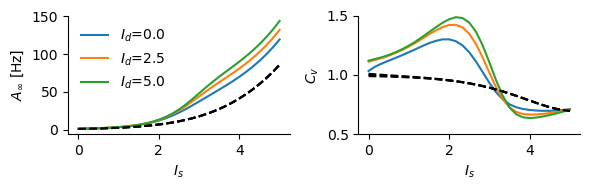

In [15]:
plot_ensemble_response_theory(A=A_theory, cv=cv_theory, A_passive=A_theory_passive, cv_passive=cv_theory_passive, 
                              I_s_vec=I_s_vec, I_d_vec=I_d_vec)

# RNN model extension

In [16]:
def rate_dendrite_integral_RNN(t, t_hat, h, dx, config):
    """
    Integral of the dendritic hazard rate over space. Non-spatial case.

    Args
    ----
        t (TYPE): DESCRIPTION.
        t_hat (TYPE): DESCRIPTION.
        params (TYPE): DESCRIPTION.

    Return
    ------
        continuous_part (TYPE): DESCRIPTION.
        continuous_part_vec (TYPE): DESCRIPTION.
        discrete_part (TYPE): DESCRIPTION.

    """
    params = config.params
    
    lambda_d = params['lambda_d']
    L = params['L']
    v_B = params['v_B']
    B = params['B']    
    
    continuous_part  = lambda_d*np.sum(relu(h), axis=1)*dx
    discrete_part = lambda_d*B*np.heaviside(L/v_B - (t-t_hat), 1)
    continuous_part_vec = lambda_d*relu(h)
    
    return continuous_part, continuous_part_vec, discrete_part

In [17]:
def monte_carlo_one_dendritic_spike_RNN(W, nb_steps, nb_neurons, dt, config):
    """
    Monte Carlo sample the two-compartment renewal model.
    
    Args
    ----
        nb_steps (TYPE): DESCRIPTION.
        dt (TYPE): DESCRIPTION.
        params (TYPE): DESCRIPTION.
        dendritic_rate (TYPE): DESCRIPTION.

    Return
    ------
        intervals (list): Somatic interspike intervals. 
        somatic_spike_train (Ndarray): Array of spikes (0's and 1's)
        dendritic_spike_train (Ndarray): Array of spikes (0's and 1's)

    """
    
    input_potential = config.input_potential
    rate_dendrite_integral = config.rate_dendrite_integral
    initial_rate_soma = config.initial_rate_soma
    rate_soma = config.rate_soma
    params = config.params

    # define grid of plocations along the dendrite
    L = params['L']
    v_B = params['v_B']
    tau_syn = params['tau_syn']
    dx = np.sqrt(3*dt)
    x_grid = np.linspace(0, L, int(L/dx)+1)
    
    # evaluate the input potential along the dendrite
    h = input_potential(X=x_grid, config=config)
    h_tile = np.tile(h, (nb_neurons, 1))
    
    somatic_intervals = []
    last_s_spike = np.zeros(nb_neurons) 
    last_d_spike = np.zeros(nb_neurons)
    last_d_spike_location = np.zeros(nb_neurons)
    
    nb_neurons_keep = 500
    somatic_spike_train = np.zeros((nb_neurons_keep, nb_steps))

    dendrite_alive = np.asarray([True]*nb_neurons)
    
    u = np.zeros((nb_neurons, len(x_grid)))
    u_new = np.zeros((nb_neurons, len(x_grid)))
    I = np.zeros(nb_neurons)
    K = np.zeros(nb_neurons)
    
    u_hist = np.zeros((nb_neurons, nb_steps))
    
    for i in trange(nb_steps):
        somatic_spike = np.zeros(nb_neurons)
        
        u_hist[:, i] = u[:, 0]
        
        h_total = h_tile + u
        
        continuous_part, continuous_part_vec, discrete_part = rate_dendrite_integral(t=i*dt, t_hat=last_s_spike*dt, h=h_total, dx=dx, config=config)
        prob_d = 1 - np.exp(-(continuous_part+discrete_part)*dt)
        
        rand_d = np.random.rand(nb_neurons)
        d_spike_boolean = (rand_d<=prob_d)
        
        d_spike_update = np.logical_and(d_spike_boolean, dendrite_alive)
        last_d_spike[d_spike_update] = i
        dendrite_alive[d_spike_update] = False
        
                
        # 1xnb_neurons size array of rates    
        initial_rate_soma_tmp = initial_rate_soma(t=i*dt, t_hat=last_s_spike*dt, h_0=h_total[:,0], config=config)
        rate_soma_tmp = rate_soma(t=i*dt, t_p=last_d_spike*dt, t_hat=last_s_spike*dt, h_0=h_total[:,0], config=config)
        
        prob_s = 1 - np.exp(-rate_soma_tmp*dt)
        prob_s[dendrite_alive] = 1 - np.exp(-initial_rate_soma_tmp[dendrite_alive]*dt)
    
        rand_s = np.random.rand(nb_neurons)
       
        s_spike_boolean = (rand_s<=prob_s)
        
        reset_dendrite = np.logical_and(s_spike_boolean, np.logical_not(dendrite_alive))
        dendrite_alive[reset_dendrite]=True
        
        somatic_spike[s_spike_boolean] = 1
        somatic_spike_train[s_spike_boolean[:nb_neurons_keep], i] = 1
        last_s_spike[s_spike_boolean] = i       
        
        # update recurrent inputs
        K_new = K + -K*dt/tau_syn + somatic_spike/tau_syn/dx
        I = np.matmul(W, K)
        
        u_new[:, 1:-1] = u[:, 1:-1]*(1-dt) + (dt/dx**2)*(u[:, 2:]+u[:, :-2]-2*u[:, 1:-1])
        
        u_new[:, 1] = u[:, 1]*(1-dt) + (dt/dx**2)*(u[:, 2]+u[:, 0]-2*u[:, 1]) + I*dt
        
        u_new[:, 0] = u[:, 0]*(1-dt) + (dt/dx**2)*(2*u[:, 1] - 2*u[:, 0])
        u_new[:, -1] = u[:, -1]*(1-dt) + (dt/dx**2)*(2*u[:, -2] - 2*u[:, -1]) 
        
        
        u = u_new
        K = K_new
        

    return somatic_spike_train, u_hist

In [18]:
def exp_convolve(A, dt, tau_conv):
    
    nb_steps = len(A)
    K = np.zeros(nb_steps)
    for i in range(nb_steps-1):
        
        K[i+1] = K[i] + -K[i]*dt/tau_conv + A[i]/tau_conv
        
        
    return K

In [19]:
def ensemble_response_RNN(I_s_RNN):
    
    nb_neurons = 500
    p = 0.2
    J_0 = -1
    w_0 = J_0 /(nb_neurons*p)

    nb_steps = int(1e6)
    dt = 0.001
    
    W = np.random.binomial(n=1, p=p, size=(nb_neurons, nb_neurons))*w_0
    
    params = default_params()
    params['I_d'] = 0
    
    A = np.zeros(len(I_d_vec))
    cv = np.zeros(len(I_d_vec))
    somatic_spike_trains = []

    for i, I_s in enumerate(I_s_RNN):
        params['I_s'] = I_s


        RNN_config = NeuronModelConfig(params=params, input_potential=input_potential_uniform, rate_dendrite_integral=rate_dendrite_integral_RNN, 
                             initial_rate_soma=initial_rate_soma, rate_soma=rate_soma, 
                                refractory_kernel=refractory_kernel_square, dendritic_kernel=dendritic_kernel_square)

        somatic_spike_train, _ = monte_carlo_one_dendritic_spike_RNN(W=W, nb_steps=nb_steps, nb_neurons=nb_neurons, dt=dt, 
                                                       config=RNN_config)
    
        intervals, As, cvs = calcualte_statistics_monte_carlo(spike_train=somatic_spike_train[:, 5000:], dt=dt, config=RNN_config)
                  
        A[i] = np.nanmean(As)
        cv[i] = np.nanmean(cvs)
        somatic_spike_trains.append(somatic_spike_train)
    
    return A, cv, somatic_spike_trains

In [20]:
I_s_RNN = np.asarray([2, 3, 4,])
A_RNN, cv_RNN, somatic_spike_trains_RNN = ensemble_response_RNN(I_s_RNN=I_s_RNN)

100%|██████████| 1000000/1000000 [24:10<00:00, 689.43it/s]


In [21]:
def plot_ensemble_response_theory_RNN(A_theory, cv_theory, A_RNN, cv_RNN, I_s_vec, I_s_RNN):
    
    params = default_params()
    tau = params['tau']
    J_0 = -1

    
    
    color = 'tab:blue'
    alpha = [1, 0.75, 0.5]
    plt.figure(figsize=(5.5,1.5))

    plt.subplot(1,3,1)
    I_s_vec_theory = np.linspace(0, 5, 31)
    A_max = 75
    for I_s in I_s_RNN: 

        A_0 = (I_s_vec_theory-I_s)/(J_0)
        A_0 = A_0/tau
        indx = A_0<A_max
        
        plt.plot(I_s_vec_theory[indx], A_0[indx], color='k')

    plt.plot(I_s_vec, A_theory[0, :], color=color, alpha=alpha[0])
    
    for i, A in enumerate(A_RNN):
        plt.hlines(A, 0, 5, color='tab:red', alpha=alpha[i], label='$I_{s}$='+f'{I_s_RNN[i]}')
         

    

    plt.xlabel('$I_{s}$')
    plt.ylabel('Frequency [Hz]')
    sns.despine()
    plt.ylim([0, 150])
    plt.yticks([0, 50, 100, 150])
    plt.xlim([0, 5])
    plt.xticks([0, 2.5, 5])
    plt.legend(frameon=False)

    plt.subplot(1,3,2)
    
    nb_steps = int(1e6)
    dt = 0.001
    
    for i, I_d in enumerate(I_d_vec):
        A = np.mean(somatic_spike_trains_RNN[i], axis=0)/tau

        A_filt = exp_convolve(A=A, dt=dt, tau_conv=.5)
        A_filt = A_filt[int(len(A_filt)/2):]

        time = np.arange(nb_steps)*dt*tau
        time = time[int(len(time)/2):]
        plt.plot((time-5)*1e3, A_filt, color='tab:blue')

        plt.hlines(A_RNN[i], 0, 500, color='tab:red', alpha=alpha[i])

    plt.ylim([0, 150])
    plt.yticks([0, 50, 100, 150])
    plt.xlim([0, 500])
    sns.despine()

    plt.xlabel('Time [ms]')
    plt.ylabel('Frequency [Hz]')
    
    plt.subplot(1,3,3)
    
    print()
    

    plt.plot(A_theory[0,:], cv_theory[0, :], label='$I_{d}$='+f'{0}', color=color, alpha=alpha[0])
    
    for i, cv in enumerate(cv_RNN):
        plt.hlines(cv, 0, 150, color='tab:red', alpha=alpha[i])
        
    for i, A in enumerate(A_RNN):
        plt.vlines(A, 0.5, 1.5, color='tab:red', alpha=alpha[i])
        
        
    plt.ylim([0.5, 1.5])
    plt.yticks([0.5, 1, 1.5])
    plt.xlim([0, 150])
    plt.xticks([0, 50, 100, 150])

    plt.xlabel('Frequency [Hz]')
    plt.ylabel('$C_{v}$')
    sns.despine()
    
    plt.tight_layout()
    
    plt.savefig('../results/RNN.svg')
    
    return

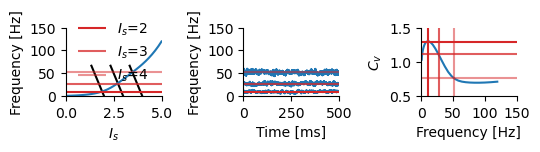

In [22]:
plot_ensemble_response_theory_RNN(A_theory=A_theory, cv_theory=cv_theory, A_RNN=A_RNN, cv_RNN=cv_RNN, I_s_vec=I_s_vec, I_s_RNN=I_s_RNN)